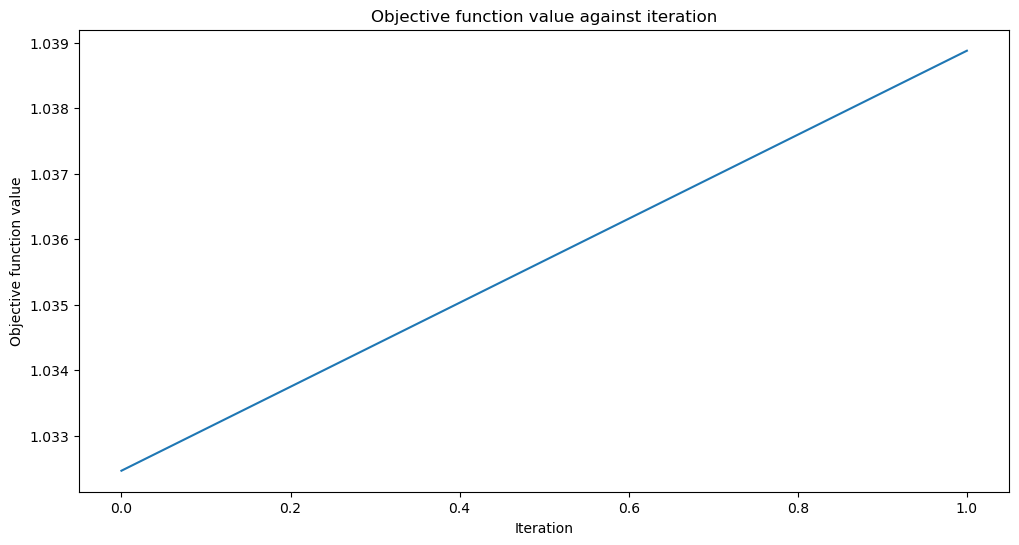

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 25 15:03:11 2024

@author: Alp Altunsoy
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from IPython.display import clear_output
import matplotlib.pyplot as plt
import json
import boto3
from datetime import datetime
from qiskit_braket_provider import BraketProvider

# Braket sağlayıcısını oluştur
provider = BraketProvider()
sv1 = provider.get_backend("Harmony")

# Verileri yükleme
print("Importing CSV train and test files")
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Satır sayısını azaltma
print("Minimizing rows of train and test datasets")
train_data = train_data.head(2000)
test_data = test_data.head(100)

# Bağımsız değişkenleri encode etme
print("Encoding independent variables")
le = LabelEncoder()
gender = le.fit_transform(train_data.iloc[:, 2])
gender = pd.DataFrame(data=gender, columns=["Gender"])
x_train = pd.concat([gender, train_data.iloc[:, 7:8], train_data.iloc[:, 22:24], train_data.iloc[:, 14:15]], axis=1)
x_test = pd.concat([gender, test_data.iloc[:, 7:8], test_data.iloc[:, 22:24], test_data.iloc[:, 14:15]], axis=1)

# Bağımlı değişkenleri oluşturma
print("Making dependent Variables")
y_train = train_data.iloc[:, -1].values
y_test = test_data.iloc[:, -1].values

# Bağımlı değişkenleri encode etme
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Verileri ölçeklendirme
print("X scaling is started")
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

# Eksik değerleri tamamlama
print("Imputing missing values")
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.fit_transform(x_test)

# Quantum algoritması
print("Quantum algorithm is started")
print("Finding features")

num_features = x_train.shape[1]

# Devre şemasını çizme
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

print("Drawing ansatz circuit")
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

optimizer = COBYLA(maxiter=100)
sampler = Sampler()

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# Callback fonksiyonunun tanımlanması
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

vqc = VQC(sampler=sampler, feature_map=feature_map, ansatz=ansatz, optimizer=optimizer, callback=callback_graph)

# Objective value geçmişini temizle
objective_func_vals = []

start = time.time()
print("Learning is started")
vqc.fit(x_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

train_score_q4 = vqc.score(x_train, y_train)
test_score_q4 = vqc.score(x_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

# Sonuçları JSON dosyasına kaydetme
scores = {
    "train_score": train_score_q4,
    "test_score": test_score_q4,
    "training time": elapsed
}
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
report_name = current_time + "_report.json"
with open(report_name, "w") as f:
    json.dump(scores, f)

print(f"Scores have been saved to '{report_name}'")

# Raporu S3'e yükleme
def upload_to_s3(file_name, bucket, object_name=None):
    if object_name is None:
        object_name = file_name
    s3_client = boto3.client('s3')
    try:
        s3_client.upload_file(file_name, bucket, object_name)
        return True
    except Exception as e:
        print(f"Error uploading file: {e}")
        return False

bucket_name = 'alposmanyeni'
if upload_to_s3(report_name, bucket_name, report_name):
    print(f"Report successfully uploaded to S3 at '{bucket_name}/{report_name}'")
else:
    print("Failed to upload the report to S3.")
